# **Dataset for Conditional Quantile Regression**

The dataset is designed for evaluating **Conditional Quantile Regression** models. It consists of a two-dimensional output variable $Y = [y_0, y_1]$ that is conditioned on a **scalar input variable** $X$.

<div align="center">
    <img src="./images/uc_marginal.png" alt="Marginal Distributions" height="300"/>
</div>

The objective is to learn the conditional distributions $P(Y \mid X = x)$ and estimate conditional quantiles for various confidence intervals and conditioning values.

A **confidence interval (CI)** is a region where the true value of $Y$ is expected to lie with a given probability $1 - \alpha$. For example, a **95% confidence interval** corresponds to $1 - \alpha = 0.95$. The qu quantiles defining the CI boundaries are:
  - Lower bound: $\alpha / 2$
  - Upper bound: $1 - \alpha / 2$

These quantile change given different conditioning values $P(Y \mid X = x'|)$, and our goal is to learn to predict/regress them
<div align="center">
    <img src="./images/uc_conditional.png" alt="Conditional" height="300"/>
</div>

---

### **Data Generation Process**

_This experiment was originally proposed in "[Calibrated Multiple-Output Quantile Regression with Representation Learning](https://arxiv.org/abs/2110.00816)" by Shai Feldman, Stephen Bates, Yaniv Romano_
- **Input Variable**: $X \in \mathbb{R}$, sampled uniformly from the interval $[-4.0, 0.8] \cup [0.8, 4.0]$.

- **Output Variable**: $Y = [y_0, y_1] \in \mathbb{R}^2$, generated according to the following equations:

  $$
  y_0 = \frac{z}{\beta |X|} + r \cos(\phi)
  $$

  $$
  y_1 = 0.5 \left( -\cos(z) + 1 \right) + r \sin(\phi) + \sin(|X|)
  $$

  Where:
  - $z \sim \text{Uniform}(-\pi, \pi)$
  - $\phi \sim \text{Uniform}(0, 2\pi)$
  - $r \sim \text{Uniform}(-0.1, 0.1)$
  - $\beta$ is a randomly sampled coefficient normalized to sum to $1$.

---

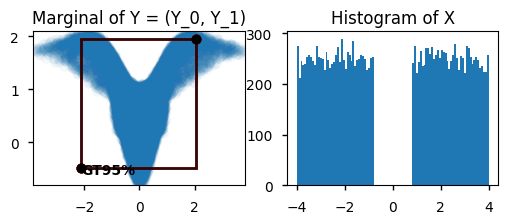

In [1]:
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.nn import BatchNorm1d, Linear, Sequential
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import random
from symm_rep_learn.inference.ncp import NCPConditionalCDF
from symm_rep_learn.models.ncp import NCP
from symm_rep_learn.nn.layers import MLP

sys.path.append(os.getcwd())
from plotting import plot_quantiles

%load_ext autoreload
%autoreload 2
plt.style.use("seaborn-v0_8-notebook")

FIG_SIZE = (3, 2)

import os
import pathlib

PLOT_PATH = pathlib.Path(os.getcwd()).parent.parent / "plots"


def synthetic_dataset(n: int, p: int = 1, condition_on_x: torch.Tensor = None):
    """Synthetic dataset from https://arxiv.org/abs/2110.00816, Appendix B.1.

    Args:
        n: sample size
        p: number of features. Defaults to 1 (used in the paper).
        condition_on_x: If None, generates marginal model. If Tesor, expects shape (1, p).
    """
    X_MIN, X_MAX = 0.8, 4
    beta_hat = torch.rand(size=(n, p))
    beta = beta_hat / torch.linalg.norm(beta_hat, ord=1, dim=1, keepdim=True)
    z = 2 * torch.pi * torch.rand(size=(n, p)) - torch.pi
    phi = 2 * torch.pi * torch.rand(size=(n, p))
    r = 2 * 0.1 * torch.rand(size=(n, p)) - 0.1
    if condition_on_x is None:
        x = torch.rand(size=(n, p)) * (X_MAX - X_MIN) + X_MIN
        x = torch.where(torch.rand(size=(n, p)) < 0.5, x, -x)  # Randomly flip sign
        y_0 = z / (beta * torch.abs(x)).sum(dim=1, keepdim=True) + r * torch.cos(phi)
        y_1 = 0.5 * (-torch.cos(z) + 1) + r * torch.sin(phi) + torch.sin(torch.abs(x)).mean(dim=1, keepdim=True)
    else:
        x = condition_on_x
        y_0 = z / (beta * torch.abs(x)).sum(dim=1, keepdim=True) + r * torch.cos(phi)
        y_1 = 0.5 * (-torch.cos(z) + 1) + r * torch.sin(phi) + torch.sin(torch.abs(x)).mean(dim=1, keepdim=True)

    return x, y_0, y_1


# Marginal of Y = (Y_0, Y_1), Fig. 1 (left) of https://arxiv.org/abs/2110.00816
x, y_0, y_1 = synthetic_dataset(n=20000, p=1)
y = np.hstack([y_0, y_1])
Y_MIN, Y_MAX = y.min(axis=0), y.max(axis=0)
X_MIN, X_MAX = x.min(), x.max()

offset = 0.2
# Compute marginal quantiles
ALPHA = 0.05  # This is multiplied by the output dimension
q_up_gt, q_lo_gt = np.quantile(y, 1 - (ALPHA / 2), axis=0), np.quantile(y, ALPHA / 2, axis=0)

fig, axs = plt.subplots(ncols=2, figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1]))
plot_quantiles(y, q_lo_gt, q_up_gt, ax=axs[0], label="", gt=True)
axs[0].set_xlim(Y_MIN[0], Y_MAX[0])
axs[0].set_ylim(Y_MIN[1], Y_MAX[1])
axs[0].set_title("Marginal of Y = (Y_0, Y_1)")
axs[1].hist(x, bins=100)
axs[1].set_title("Histogram of X")
fig.savefig(pathlib.Path(os.getcwd()) / "images" / "uc_marginal.png", dpi=250)

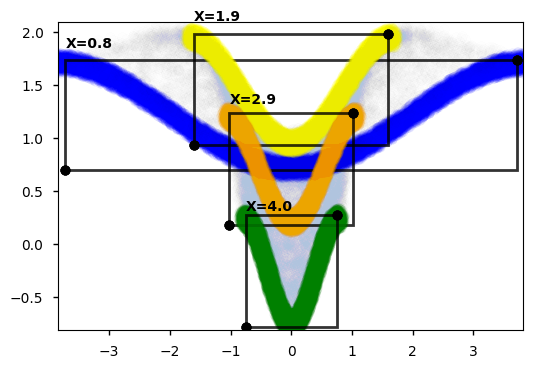

In [2]:
# Condition of Y = (Y_0, Y_1) | X = [1.5, 2, 2.5], Fig. 1 (right) of https://arxiv.org/abs/2110.00816
fig, ax = plt.subplots(figsize=[2 * a for a in FIG_SIZE])
x_cond_vals = np.linspace(float(x.abs().min().item()), float(x.abs().max().item()), 4)
colors = ["blue", "yellow", "orange", "green"]
ax.set_xlim(Y_MIN[0], Y_MAX[0])
ax.set_ylim(Y_MIN[1], Y_MAX[1])
ax.scatter(y[:, 0], y[:, 1], alpha=0.01, color="lightsteelblue")
for j, (x_cond, color) in enumerate(zip(x_cond_vals, colors)):
    _, y_0, y_1 = synthetic_dataset(n=20000, condition_on_x=torch.Tensor([x_cond]).reshape(-1, 1))
    y_cond_x = np.hstack([y_0, y_1])
    q_up_gt, q_lo_gt = np.quantile(y_cond_x, 1 - (ALPHA / 2), axis=0), np.quantile(y_cond_x, (ALPHA / 2), axis=0)
    plot_quantiles(y_cond_x, q_lo_gt, q_up_gt, ax=ax, label=f"X={x_cond:.1f}", gt=False, quantile_color="black", color=color)
# ax.set_title("Conditional dist of Y | X=x")
# fig.tight_layout()
fig.savefig(pathlib.Path(os.getcwd()) / "images" / "uc_conditional.png", dpi=250)

# Experiment configuration

In [3]:
# CONFIG================================================================================================================
SAMPLE_SIZE = 20000  # (Table 4)
BATCH_SIZE = 1024  # (Appendix C)
EPOCHS = 500
DEVICE = "cuda:0"
# ======================================================================================================================

# GET DATA==============================================================================================================
x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1)
y = torch.hstack([y_0, y_1])

# Split dataset intro train, calibration, validation, and test
ntrain, ncal, nval, ntest = (
    int(0.384 * SAMPLE_SIZE),
    int(0.256 * SAMPLE_SIZE),
    int(0.16 * SAMPLE_SIZE),
    int(0.2 * SAMPLE_SIZE),
)
x_train, y_train = x[: ntrain + ncal, :], y[: ntrain + ncal, :]
x_train_mlp, y_train_mlp = x[:ntrain, :], y[:ntrain, :]
x_cal, y_cal = x[ntrain : ntrain + ncal, :], y[ntrain : ntrain + ncal, :]
x_val, y_val = x[ntrain + ncal : ntrain + ncal + nval, :], y[ntrain + ncal : ntrain + ncal + nval, :]
x_test, y_test = x[ntrain + ncal + nval :, :], y[ntrain + ncal + nval :, :]
print(f"Sanity check: train={x_train.shape[0]}, cal={x_cal.shape[0]}, val={x_val.shape[0]}, test={x_test.shape[0]}")

# Standardize datasets
x_train_mean = x_train.mean(dim=0)
y_train_mean = y_train.mean(dim=0)
x_train_std = x_train.std(dim=0)
y_train_std = y_train.std(dim=0)

x_train = (x_train - x_train_mean) / x_train_std
y_train = (y_train - y_train_mean) / y_train_std
x_train_mlp = (x_train_mlp - x_train_mean) / x_train_std
y_train_mlp = (y_train_mlp - y_train_mean) / y_train_std

x_cal = (x_cal - x_train_mean) / x_train_std
y_cal = (y_cal - y_train_mean) / y_train_std

x_val = (x_val - x_train_mean) / x_train_std
y_val = (y_val - y_train_mean) / y_train_std

x_test = (x_test - x_train_mean) / x_train_std
y_test = (y_test - y_train_mean) / y_train_std

# Wrap tensors into Dataset and DataLoader
train_ds = TensorDataset(x_train, y_train)
train_mlp_ds = TensorDataset(x_train_mlp, y_train_mlp)
cal_ds = TensorDataset(x_cal, y_cal)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)

train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
train_dl_mlp = DataLoader(train_mlp_ds, shuffle=True, batch_size=BATCH_SIZE)
cal_dl = DataLoader(cal_ds, shuffle=False, batch_size=len(cal_ds))
val_dl = DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

Sanity check: train=12800, cal=5120, val=3200, test=4000


# Training data-driven models
## **Multivariate Conformalized Quantile Regression (CQR)**

Multivariate Conformalized Quantile Regression (CQR) is a neural network-based approach, typically employing a Multilayer Perceptron (MLP), to estimate conditional quantiles of a multivariate random variable $Y \in \mathbb{R}^d$ given $X \in \mathbb{R}^p$.

The model is trained to predict specific quantiles corresponding to pre-defined confidence levels (e.g., 0.1, 0.5, 0.9) for a desired coverage probability $1 - \alpha$. During training, the MLP learns mappings from $X$ to the desired quantiles of $Y$.


In [4]:
def pinball_loss(input: torch.Tensor, target: torch.Tensor, gamma: float):
    """Pinball loss of https://arxiv.org/pdf/2107.07511 (page 8) to learn (gamma/2)-quantiles.

    Args:
        input: Model output.
        target: Ground truth.
        gamma: Quantile to regress.

    """
    errors = target - input
    loss = torch.maximum(errors * gamma, -errors * (1 - gamma)).mean()
    return loss


def make_mlp(
    input_dim: int = 1,
    output_dim: int = 2,
    layer_size: int = 32,
    n_hidden_layers: int = 2,
    activation: torch.nn.Module = torch.nn.ELU,
):
    layers = [Linear(input_dim, layer_size), activation(), BatchNorm1d(layer_size)]
    for _ in range(n_hidden_layers - 1):
        layers += [Linear(layer_size, layer_size), activation(), BatchNorm1d(layer_size)]
    layers += [Linear(layer_size, output_dim), activation()]
    return Sequential(*layers)


# GET MODEL=============================================================================================================
# TODO: Implement multivariate QR as in the paper
lower_quantile_estimator = make_mlp(output_dim=2, layer_size=64, n_hidden_layers=3).to(DEVICE)
upper_quantile_estimator = make_mlp(output_dim=2, layer_size=64, n_hidden_layers=3).to(DEVICE)

# TRAIN MODEL===========================================================================================================
# TODO: Change to a single model
opt_lo = torch.optim.Adam(lr=5e-4, params=lower_quantile_estimator.parameters())
opt_up = torch.optim.Adam(lr=5e-4, params=upper_quantile_estimator.parameters())


def train(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    train_dl: DataLoader,
    opt_lo: torch.optim.Optimizer,
    opt_up: torch.optim.Optimizer,
):
    lo_q_est.train()
    up_q_est.train()
    for batch, (x, y) in enumerate(train_dl):
        x, y = x.to(DEVICE), y.to(DEVICE)
        q_lo, q_up = lo_q_est(x), up_q_est(x)

        loss_lo = pinball_loss(input=q_lo, target=y, gamma=ALPHA / 2)
        loss_up = pinball_loss(input=q_up, target=y, gamma=1 - (ALPHA / 2))

        loss_lo.backward()
        loss_up.backward()

        opt_lo.step()
        opt_up.step()

        opt_lo.zero_grad()
        opt_up.zero_grad()

@torch.no_grad()
def validate(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    val_dl: DataLoader
):
    """Compute validation loss."""
    lo_q_est.eval()
    up_q_est.eval()
    total_loss = 0
    
    for x, y in val_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        q_lo, q_up = lo_q_est(x), up_q_est(x)
        
        loss_lo = pinball_loss(input=q_lo, target=y, gamma=ALPHA / 2)
        loss_up = pinball_loss(input=q_up, target=y, gamma=1 - (ALPHA / 2))
        total_loss += (loss_lo + loss_up).item()
    
    return total_loss / len(val_dl)

# Training with early stopping
best_val_loss = float('inf')
patience_counter = 0
patience = 5  # Stop after 3 consecutive validation increases

# Save initial state
best_lower_state = lower_quantile_estimator.state_dict().copy()
best_upper_state = upper_quantile_estimator.state_dict().copy()

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    train(
        lo_q_est=lower_quantile_estimator,
        up_q_est=upper_quantile_estimator,
        train_dl=train_dl_mlp,
        opt_lo=opt_lo,
        opt_up=opt_up,
    )

    if epoch % 10 == 0:
        val_loss = validate(
            lo_q_est=lower_quantile_estimator,
            up_q_est=upper_quantile_estimator,
            val_dl=val_dl,
        )
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model states
            best_lower_state = lower_quantile_estimator.state_dict().copy()
            best_upper_state = upper_quantile_estimator.state_dict().copy()
            # print(f"Epoch {epoch}: New best validation loss: {val_loss:.4f}")
        else:
            patience_counter += 1
            # print(f"Epoch {epoch}: Val loss: {val_loss:.4f} (no improvement, patience: {patience_counter}/{patience})")
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

# Restore best model
lower_quantile_estimator.load_state_dict(best_lower_state)
upper_quantile_estimator.load_state_dict(best_upper_state)
print(f"Restored model with validation loss: {best_val_loss:.4f}")

# CALIBRATION===========================================================================================================


def calibrate(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    cal_ds: TensorDataset,
):
    lo_q_est.eval()
    up_q_est.eval()
    n_cal = len(cal_ds)
    adjusted_alpha = math.ceil((n_cal + 1) * (1 - ALPHA)) / n_cal

    with torch.no_grad():
        x, y = cal_ds.tensors
        x, y = x.to(DEVICE), y.to(DEVICE)

        q_lo, q_up = lo_q_est(x), up_q_est(x)

        nonconformity_scores = torch.maximum(q_lo - y, y - q_up).max(dim=1, keepdim=True)[0]

        q_hat = torch.quantile(nonconformity_scores, adjusted_alpha, interpolation="higher").item()

        return q_hat


q_hat = calibrate(lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, cal_ds=cal_ds)
print(f"Empirical Quantile Estimated with CP: {q_hat}")


# EVALUATION============================================================================================================
def test_mlp(lo_q_est: torch.nn.Module, up_q_est: torch.nn.Module, test_dl: DataLoader, q_hat: float):
    coverage = 0
    set_size = 0
    lo_q_est.eval()
    up_q_est.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x.to(DEVICE), y.to(DEVICE)

            # Conformalize quantile estimates
            q_lo, q_up = lo_q_est(x) - q_hat, up_q_est(x) + q_hat

            coverage += ((q_lo <= y).all(dim=1, keepdim=True) & (y <= q_up).all(dim=1, keepdim=True)).type_as(y).mean()
            set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean()
    coverage /= len(test_dl)
    set_size /= len(test_dl)

    return coverage, set_size


coverage, set_size = test_mlp(
    lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, test_dl=test_dl, q_hat=q_hat
)
print(f"Avg. empirical coverage: {coverage.item() * 100:.2f}% Avg. set size: {set_size.item():.2f}")

Epochs:  46%|████▌     | 230/500 [00:09<00:11, 23.90it/s]


Early stopping at epoch 230
Restored model with validation loss: 0.1400
Empirical Quantile Estimated with CP: 1.0932211875915527
Avg. empirical coverage: 94.59% Avg. set size: 16.06


### Example use of CQR

Text(0.5, 0.98, 'CQR prediction for X=2.70')

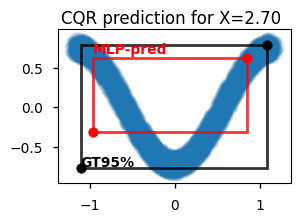

In [5]:
# Quantile Regression, Fig 2 of https://arxiv.org/abs/2110.00816
X_cond = 2.7
x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=torch.Tensor([X_cond]).reshape(1, 1))
y = torch.hstack([y_0, y_1])
y_c = (y - y_train_mean) / y_train_std
x_c = (x - x_train_mean) / x_train_std
low_q = torch.squeeze(lower_quantile_estimator(x_c.to(DEVICE))).detach().cpu().numpy()
up_q = torch.squeeze(upper_quantile_estimator(x_c.to(DEVICE))).detach().cpu().numpy()

y_c = y_c.cpu().numpy()

fig, ax = plt.subplots(figsize=FIG_SIZE)
plot_quantiles(y_c, low_q, up_q, ax=ax, label="MLP-pred", alpha=ALPHA)
fig.suptitle(rf"CQR prediction for X={X_cond:.2f}")

## **Neural Conditional Probability** (NCP)


Neural Conditional Probability (NCP) is a representation learning algorithm designed for various inference tasks, including quantile regression. It learns non-linear transformations of the random variables $X$ and $Y$ by approximating the **conditional expectation operator**.

---

### **Marginal Cumulative Distribution Function (CDF)**
The marginal CDF of a random variable $Y \in \mathbb{R}^d$ is defined as:

$$
F_Y(y) = \mathbb{P}(Y \leq y)
$$

This function provides the probability that $Y$ takes values less than or equal to $y$ in the marginal (unconditioned) case.

---

### **Conditional Cumulative Distribution Function (CondCDF)**
The Conditional CDF (CondCDF) for a given $X = x$ is defined as:

$$
F_{Y \mid X}(y \mid x) = \mathbb{P}(Y \leq y \mid X = x)
$$

This function describes the probability that $Y$ takes values less than or equal to $y$, conditioned on a specific value of $X = x$.

---

### **Approach**
NCP approximates the **conditional expectation operator** $\mathbb{E}[Y \mid X = x]$, allowing the model to simultaneously learn data representations for $X$ and $Y$. Using these representations, the model regresses the CondCDF by learning how to deform the **marginal CDF** $F_Y(y)$ to obtain the corresponding **CondCDF** $F_{Y \mid X}(y \mid x)$ for each conditioning value $x$.

Essentially, the model captures how the distribution of $Y$ changes in response to changes in $X$, enabling effective quantile regression and other uncertainty quantification tasks.


In [ ]:
import numpy as np

embedding_dim = 16
ncp = NCP(
    embedding_x=MLP(input_shape=1, output_shape=embedding_dim, layer_size=64, n_hidden=3, activation=torch.nn.ELU, bias=True),
    embedding_y=MLP(input_shape=2, output_shape=embedding_dim, layer_size=64, n_hidden=3, activation=torch.nn.ELU, bias=True),
    embedding_dim_x=embedding_dim,
    embedding_dim_y=embedding_dim,
    orth_reg=2.5,
).to(DEVICE)

lr = 5e-4
ncp_optimizer = torch.optim.Adam(ncp.parameters(), lr=lr)

CHECK_VAL_EVERY_N_EPOCHS = int(EPOCHS / 10)

@torch.no_grad()
def validate_ncp(model: torch.nn.Module, val_dl: DataLoader):
    """Compute validation metric for NCP - tracking ||k(x,y) - k_r(x,y)||."""
    model.eval()
    total_metric = 0
    
    for x, y in val_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        fx, hy = model(x, y)
        _, metrics = model.loss(fx, hy)
        total_metric += metrics["||k(x,y) - k_r(x,y)||"]
    
    return total_metric / len(val_dl)

# Training with early stopping
best_val_metric = float('inf')
patience_counter = 0
patience = 5  # Stop after 5 consecutive validation metric increases

# Save initial state
best_ncp_state = ncp.state_dict().copy()

# Initialize the progress bar
pbar = tqdm(range(EPOCHS), desc="Epochs")

relevant_metrics = ["tr(Cx)", "tr(Cy)", "||k(x,y) - k_r(x,y)||"]
val_metric = np.infty

for epoch in pbar:
    ncp.train()
    for x, y in train_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        ncp_optimizer.zero_grad()
        fx, hy = ncp(x, y)
        loss, metrics = ncp.loss(fx, hy)

        loss.backward()
        ncp_optimizer.step()

        # Update the progress bar with the loss
        pbar.set_postfix(
            loss=loss.item(), val_metric=val_metric, **{k: v for k, v in metrics.items() if k in relevant_metrics}
        )
    
    if epoch % CHECK_VAL_EVERY_N_EPOCHS == 0 or epoch == EPOCHS - 1:
        val_metric = validate_ncp(model=ncp, val_dl=val_dl)
        
        if val_metric < best_val_metric:
            best_val_metric = val_metric
            patience_counter = 0
            # Save best model state
            best_ncp_state = ncp.state_dict().copy()
            # print(f"Epoch {epoch}: New best validation metric: {val_metric:.4f}")
        else:
            patience_counter += 1
            # print(f"Epoch {epoch}: Val metric: {val_metric:.4f} (no improvement, patience: {patience_counter}/{patience})")
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

# Restore best model
ncp.load_state_dict(best_ncp_state)
print(f"Restored NCP model with validation ||k(x,y) - k_r(x,y)||: {best_val_metric:.4f}")

Epochs: 100%|██████████| 500/500 [00:49<00:00, 10.01it/s, loss=-0.231, val_metric=-2.18, ||k(x,y) - k_r(x,y)||=-2.19]  

Restored NCP model with validation ||k(x,y) - k_r(x,y)||: -2.2547


In [7]:
from symm_rep_learn.inference.ncp import NCPConditionalCDF

# EVALUATION============================================================================================================
def test_ncp_uc(model: NCPConditionalCDF, test_dl: DataLoader):
    coverage = 0
    set_size = 0
    model.eval()
    model.to(DEVICE)
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x.to(DEVICE), y.to(DEVICE)
            # Conformalize quantile estimates
            q_lo, q_up = model.conditional_quantiles(x_cond=x, alpha=ALPHA)
            q_lo = torch.tensor(q_lo, device=DEVICE, dtype=torch.float32)
            q_up = torch.tensor(q_up, device=DEVICE, dtype=torch.float32)
            coverage += ((q_lo <= y).all(dim=1, keepdim=True) & (y <= q_up).all(dim=1, keepdim=True)).type_as(y).mean()
            set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean()
    coverage /= len(test_dl)
    set_size /= len(test_dl)

    return coverage, set_size


# Use the train NCP model for Conditional CDF regression.
ncp_ccdf = NCPConditionalCDF(model=ncp, y_train=y_train, support_discretization_points=1000, ridge_reg=1e-3)

coverage, set_size = test_ncp_uc(model=ncp_ccdf, test_dl=test_dl)
print(
    f"Avg. empirical coverage: {coverage.item() * 100:.1f}% Avg - "
    f"Expected {(1 - ALPHA) * 100:.1f}. \nSet size: {set_size.item():.2f}"
)

Avg. empirical coverage: 95.7% Avg - Expected 95.0. 
Set size: 6.87


### **Visualizing Learned Data Representations (Basis Functions)**

In this section, we visualize the **basis functions** learned by the model as part of the non-linear transformations applied to the random variables $X$ and $Y$. These functions approximate an orthonormal basis set capable of representing a broad class of functions in the spaces $L^2_{P_X}$ and $L^2_{P_Y}$.

A crucial characteristic of these basis sets is that they enable the computation of the **conditional expectation** of any observable $\psi(y)$ belonging to the basis set. Specifically, we can compute:

$$
\mathbb{E}_{Y \mid X = x} \left[ \psi(Y) \mid X = x \right]
$$

using the learned data representations and the approximated **conditional expectation operator**.

This property is particularly powerful because, if we regress the **CondCDF** in terms of all basis functions $\{ \psi_i \}$, we can effectively compute the conditioning of the CondCDF for every $X$ in the training distribution of the NCP model. By leveraging the learned basis set, the model provides a flexible and efficient mechanism for capturing conditional dependencies across a wide range of observables.


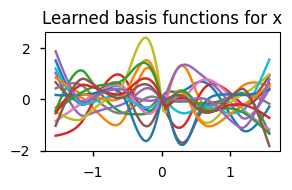

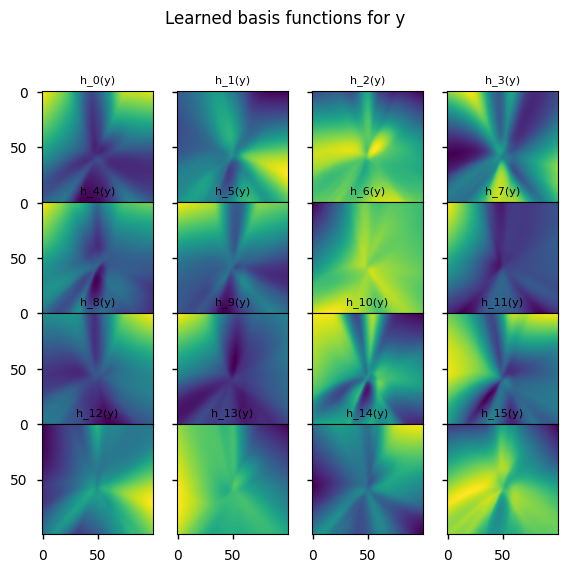

In [8]:
# Plot the learned basis functions for x ==============================================================
x_range = torch.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1).to(DEVICE)
with torch.no_grad():
    fx, _ = ncp(x=x_range)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(FIG_SIZE[0], FIG_SIZE[1]))
for i in range(embedding_dim):
    ax.plot(x_range.cpu().numpy(), fx[:, i].cpu().numpy(), label=f"f_{i}(x)")
fig.set_tight_layout(True)
ax.set_title("Learned basis functions for x")
# Plot the learned basis functions for y ==============================================================
# Plot the `embedding_y` basis functions as 2D images.
N_GRID_POINTS = 100
y0_range = np.linspace(y_train[:, 0].min().numpy(), y_train[:, 0].max().numpy(), N_GRID_POINTS).reshape(-1)
y1_range = np.linspace(y_train[:, 1].min().numpy(), y_train[:, 1].max().numpy(), N_GRID_POINTS).reshape(-1)
# Generate the 2D grid of sample points
y0_grid, y1_grid = np.meshgrid(y0_range, y1_range)
y_grid = torch.tensor(np.vstack([y0_grid.ravel(), y1_grid.ravel()]).T, device=DEVICE, dtype=torch.float32)
with torch.no_grad():
    _, hy = ncp(y=y_grid)
    # Reshape back to 2D images (100, 100, embedding_dim)
    hy = hy.reshape(N_GRID_POINTS, N_GRID_POINTS, embedding_dim)

nrows = math.ceil(embedding_dim / 4)
fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1] * 2.9), sharey=True, sharex=True)
for i in range(embedding_dim):
    ax = axs[i // 4, i % 4]
    ax.imshow(hy[:, :, i].cpu().numpy())  # extent=(y0_range.min(), y0_range.max(), y1_range.min(), y1_range.max()))
    ax.set_title(f"h_{i}(y)", fontsize=8)
fig.suptitle("Learned basis functions for y")
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(wspace=0.00, hspace=0.0)
fig.savefig(PLOT_PATH / "ncp_y_basis_functions.png", dpi=250)

### **NCP Regression of the Conditional CDF (CondCDF)**

In this cell, we demonstrate how to **regress the CondCDF** using the learned basis functions and the approximated conditional expectation operator. This approach enables us to compute the CondCDF for any input $X = x$ and use it to derive predicted quantiles for arbitrary confidence interval probabilities.

---

#### **Why Regress the CondCDF?**
The **CondCDF** is a fundamental object in probabilistic regression and uncertainty quantification. By approximating the CondCDF, we can compute quantiles for **any desired confidence level** without retraining the model. Unlike standard quantile regression methods that require retraining for different probabilities, the NCP model learns the entire distribution through the operator approximation.

---

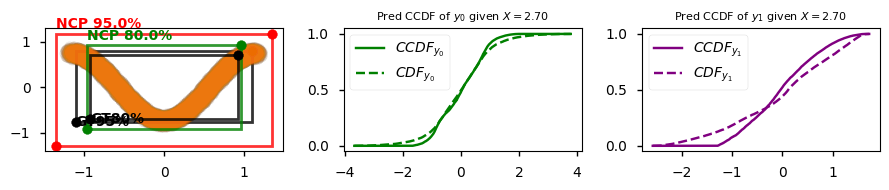

In [9]:
x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=torch.Tensor([X_cond]).reshape(1, 1))
y = torch.hstack([y_0, y_1])
y_c = (y - y_train_mean) / y_train_std
x_c = (x - x_train_mean) / x_train_std

# Estimate the conditional Cumulative Distribution Function (CCDF)
ccdf = ncp_ccdf(x_cond=x_c)

alphas = [0.05, 0.2]
fig, axs = plt.subplots(1, 3, figsize=(FIG_SIZE[0] * 3, 1 * FIG_SIZE[1]))
for alpha, color in zip(alphas, ["red", "green", "purple"]):
    q_low, q_high = ncp_ccdf.conditional_quantiles(x_cond=x_c, alpha=alpha)
    plot_quantiles(
        y_c, q_low, q_high, label=f"NCP {(1 - alpha) * 100:.1f}%", alpha=alpha, ax=axs[0], quantile_color=color
    )
    # PLot the marginal CDF of each dimension
axs[1].plot(ncp_ccdf.support_obs[:, 0], ccdf[:, 0], label=r"$CCDF_{y_0}$", color="green")
axs[1].plot(
    ncp_ccdf.support_obs[:, 0], ncp_ccdf.marginal_CDF[:, 0], label=r"$CDF_{y_0}$", color="green", linestyle="--"
)
axs[1].set_title(rf"Pred CCDF of $y_0$ given $X={X_cond:.2f}$", fontsize=8)
axs[2].plot(ncp_ccdf.support_obs[:, 1], ccdf[:, 1], label=r"$CCDF_{y_1}$", color="purple")
axs[2].plot(
    ncp_ccdf.support_obs[:, 1], ncp_ccdf.marginal_CDF[:, 1], label=r"$CDF_{y_1}$", color="purple", linestyle="--"
)
axs[2].set_title(rf"Pred CCDF of $y_1$ given $X={X_cond:.2f}$", fontsize=8)
axs[1].legend()
axs[2].legend()
fig.tight_layout()
fig.savefig(PLOT_PATH / "ncp_ccdf_regression.png", dpi=250)

## **Training E-NCP Model (Our Model)**

The **E-NCP model** is an extension of the **Neural Conditional Probability (NCP)** approach designed to leverage the inherent **symmetries** present in the data distributions of $X$ and $Y$. By incorporating these symmetries explicitly, the E-NCP model improves the efficiency and robustness of the learning process.

---

### **Symmetries in the Data Distribution**

In our setting, the data distributions of $X$ and $Y$ exhibit specific symmetries related to the **reflection symmetry group**:

- **Reflection Symmetry Group** $\mathbb{G} = \mathbb{C}_2 = \{e, g_r \mid g_r^2 = e\}$

- **Symmetries of $X$ (Inputs):**
  - $P(X) = P(g_r X) = P(X)$
  - This implies that applying the reflection transformation $g_r$ to $X$ leaves the distribution invariant.

- **Symmetries of $Y$ (Outputs):**
  - For $Y = (y_0, y_1)$, the symmetries are:
    - $P(y_0) = P(g_r y_0) = P(-y_0)$ (reflection symmetry along the $y_0$ axis)
    - $P(y_1) = P(g_r y_1) = P(y_1)$ (invariant under reflection)

---

In [10]:
import numpy as np
from escnn.group import CyclicGroup
from escnn.gspaces import no_base_space
from escnn.nn import FieldType

from symm_rep_learn.inference.encp import ENCPConditionalCDF
from symm_rep_learn.models.equiv_ncp import ENCP
from symm_rep_learn.nn.equiv_layers import EMLP

G = CyclicGroup(2)
x_type = FieldType(no_base_space(G), representations=[G.representations["irrep_0"]])
# y0 transforms by reflections g. y0 = -y0
# y1 transforms by invariance  g. y1 = y1
y_type = FieldType(no_base_space(G), representations=[G.representations["irrep_1"], G.representations["irrep_0"]])
embedding_dim = 16
lat_type = FieldType(no_base_space(G), representations=[G.regular_representation] * int(embedding_dim // G.order()))

encp = ENCP(
    embedding_x=EMLP(in_type=x_type, out_type=lat_type, hidden_units=64, hidden_layers=3, activation="ELU"),
    embedding_y=EMLP(in_type=y_type, out_type=lat_type, hidden_units=64, hidden_layers=3, activation="ELU"),
    embedding_dim_x=embedding_dim,
    embedding_dim_y=embedding_dim,
    orth_reg=2.5,
).to(DEVICE)

lr = 5e-4
encp_optimizer = torch.optim.Adam(encp.parameters(), lr=lr)

CHECK_VAL_EVERY_N_EPOCHS = int(EPOCHS / 10)

@torch.no_grad()
def validate_encp(model: torch.nn.Module, val_dl: DataLoader):
    """Compute validation metric for E-NCP - tracking ||k(x,y) - k_r(x,y)||."""
    model.eval()
    total_metric = 0
    
    for x, y in val_dl:
        x, y = x_type(x).to(DEVICE), y_type(y).to(DEVICE)
        fx, hy = model(x, y)
        _, metrics = model.loss(fx, hy)
        total_metric += metrics["||k(x,y) - k_r(x,y)||"]
    
    return total_metric / len(val_dl)

# Training with early stopping
best_val_metric = float('inf')
patience_counter = 0
patience = 5  # Stop after 5 consecutive validation metric increases

# Save initial state
best_encp_state = encp.state_dict().copy()

# Initialize the progress bar
pbar = tqdm(range(EPOCHS), desc="Epochs")
relevant_metrics = ["tr(Cx)", "tr(Cy)", "||k(x,y) - k_r(x,y)||"]
val_metric = np.infty

for epoch in pbar:
    encp.train()
    for x, y in train_dl:
        x, y = x_type(x).to(DEVICE), y_type(y).to(DEVICE)
        encp_optimizer.zero_grad()
        fx, hy = encp(x, y)
        loss, metrics = encp.loss(fx, hy)

        loss.backward()
        encp_optimizer.step()

        # Update the progress bar with the loss
        pbar.set_postfix(
            loss=loss.item(), val_metric=val_metric, **{k: v for k, v in metrics.items() if k in relevant_metrics}
        )
    
    if epoch % CHECK_VAL_EVERY_N_EPOCHS == 0:
        val_metric = validate_encp(model=encp, val_dl=val_dl)
        
        if val_metric < best_val_metric:
            best_val_metric = val_metric
            patience_counter = 0
            # Save best model state
            best_encp_state = encp.state_dict().copy()
            # print(f"Epoch {epoch}: New best validation metric: {val_metric:.4f}")
        else:
            patience_counter += 1
            # print(f"Epoch {epoch}: Val metric: {val_metric:.4f} (no improvement, patience: {patience_counter}/{patience})")
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

# Restore best model
encp.load_state_dict(best_encp_state)
print(f"Restored E-NCP model with validation ||k(x,y) - k_r(x,y)||: {best_val_metric:.4f}")

TypeError: ENCP.__init__() got an unexpected keyword argument 'embedding_dim_x'

In [ ]:
# Use the E-NCP model for Conditional CDF regression.
encp_ccdf = ENCPConditionalCDF(model=encp, y_train=y_type(y_train), support_discretization_points=1000, lstsq=False)


# EVALUATION============================================================================================================
def test_encp_uc(model: ENCPConditionalCDF, test_dl: DataLoader):
    coverage = 0
    set_size = 0
    model.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x_type(x).to(DEVICE), y_type(y).to(DEVICE)
            # Conformalize quantile estimates
            q_lo, q_up = model.conditional_quantiles(x_cond=x, alpha=ALPHA)
            q_lo = torch.tensor(q_lo, device=DEVICE, dtype=torch.float32)
            q_up = torch.tensor(q_up, device=DEVICE, dtype=torch.float32)
            coverage += (
                ((q_lo <= y.tensor).all(dim=1, keepdim=True) & (y.tensor <= q_up).all(dim=1, keepdim=True))
                .type_as(y.tensor)
                .mean()
            )
            set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean()
    coverage /= len(test_dl)
    set_size /= len(test_dl)

    return coverage, set_size


coverage, set_size = test_encp_uc(model=encp_ccdf, test_dl=test_dl)
print(
    f"Avg. empirical coverage: {coverage.item() * 100:.1f}% Avg - "
    f"Expected {(1 - ALPHA) * 100:.1f}. \nSet size: {set_size.item():.2f}"
)

Avg. empirical coverage: 93.3% Avg - Expected 95.0. 
Set size: 7.37


### **Learned Basis Functions**

The E-NCP model learns **basis functions** for the random variables $X$ and $Y$ through the approximation of the conditional expectation operator. Importantly, the symmetries in the data distributions influence the nature of these learned functions.

---

#### **Basis Functions for $X$ (Unconstrained)**

Since $X$ is **invariant** under the group action $\mathbb{G}$, the learned basis functions for $X$ are **unconstrained**. This means that the model is free to learn a rich set of representations without symmetry-based restrictions. The learned basis functions capture relevant features of $X$ for regression tasks but are not explicitly affected by the symmetries of the group $\mathbb{G}$.

$$
P(X) = P(g_r X) = P(X)
$$

---

#### **Basis Functions for $Y \in \mathbb{R}^2$ (Constrained by Symmetry)**

The variable $Y = (y_0, y_1)$ exhibits **reflection symmetry** under the group action $\mathbb{G} = \mathbb{C}_2 = \{e, g_r\}$. This group acts differently on the components $y_0$ and $y_1$:

- $y_0$: **Reflection Symmetry**, $P(y_0) = P(-y_0)$
- $y_1$: **Invariant under reflection**, $P(y_1) = P(g_r y_1) = P(y_1)$

Since the model must respect these symmetries, the **learned basis functions for $Y$** are constrained to capture these properties. Specifically:

- **For $y_0$:** The learned basis functions must be **even functions** (symmetric) under reflection $g_r$, ensuring $P(y_0) = P(-y_0)$.
- **For $y_1$:** The learned basis functions are **unaffected** by $g_r$, meaning they are invariant under the group action.

---

#### **Constraining the Model for $G$-Invariant Functions**

Since the **CondCDF** of $y_0$ and $y_1$ is a $G$-invariant function, the model is constrained to **learn only $G$-invariant functions of $Y$**. This is achieved by restricting the learned basis functions to those


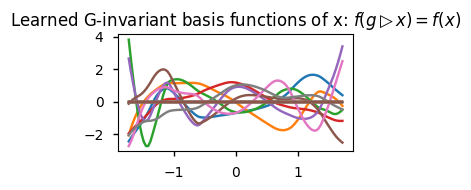

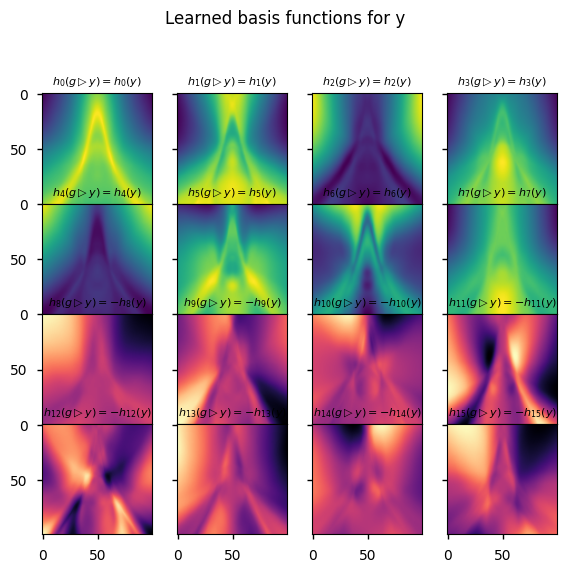

In [ ]:
# Plot the learned basis functions for x ==============================================================
x_range = torch.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1).to(DEVICE)
with torch.no_grad():
    fx = encp.embedding_x(x_type(x_range)).tensor
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(FIG_SIZE[0], FIG_SIZE[1]))
for i in range(int(embedding_dim)):
    ax.plot(x_range.cpu().numpy(), fx[:, i].cpu().numpy(), label=f"f_{i}(x)")
# for i in range(int(embedding_dim // 2), embedding_dim):
#     axs[1].plot(x_range.cpu().numpy(), fx[:, i].cpu().numpy(), label=f"f_{i}(x)")
ax.set_title(r"Learned G-invariant basis functions of x: $f(g \triangleright x) = f(x)$")
# axs[1].set_title(rf"Learned G-equivariant basis functions of x: $f(g \triangleright x) = -f(x)$")

fig.set_tight_layout(True)

# Plot the `embedding_y` basis functions as 2D images. ====================================================
N_GRID_POINTS = 100
y0_range = np.linspace(y_train[:, 0].min().numpy(), y_train[:, 0].max().numpy(), N_GRID_POINTS).reshape(-1)
y1_range = np.linspace(y_train[:, 1].min().numpy(), y_train[:, 1].max().numpy(), N_GRID_POINTS).reshape(-1)
# Generate the 2D grid of sample points
y0_grid, y1_grid = np.meshgrid(y0_range, y1_range)
y_grid = torch.tensor(np.vstack([y0_grid.ravel(), y1_grid.ravel()]).T, device=DEVICE, dtype=torch.float32)
with torch.no_grad():
    hy = encp.embedding_y(y_type(y_grid)).tensor
    # Reshape back to 2D images (100, 100, embedding_dim)
    hy = hy.reshape(N_GRID_POINTS, N_GRID_POINTS, embedding_dim)

nrows = math.ceil(embedding_dim / 4)
fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1] * 2.9), sharey=True, sharex=True)
for i in range(int(embedding_dim)):
    ax = axs[i // 4, i % 4]
    if i < 8:
        ax.imshow(hy[:, :, i].cpu().numpy())
        ax.set_title(
            rf"$h_{{{i}}}(g \triangleright y) = h_{{{i}}}(y)$", fontsize=8
        )  # for i in range(int(embedding_dim // 2), embedding_dim):
    else:
        ax.imshow(hy[:, :, i].cpu().numpy(), cmap="magma")
        ax.set_title(
            rf"$h_{{{i}}}(g \triangleright y) = -h_{{{i}}}(y)$", fontsize=8
        )  # for i in range(int(embedding_dim // 2), embedding_dim):

    # Set fontsize
#     ax = axs[i // 4, i % 4]
#     ax.imshow(hy[:, :, i].cpu().numpy())  # extent=(y0_range.min(), y0_range.max(), y1_range.min(), y1_range.max()))
#     ax.set_title(rf"$h_{i}(g \triangleright y) = g \triangleright h_{i}(y)$")

fig.suptitle("Learned basis functions for y")
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(wspace=0.00, hspace=0.0)
fig.savefig(PLOT_PATH / "encp_y_basis_functions.png", dpi=250)

## Use E-NCP for G-equivariant quantile regression

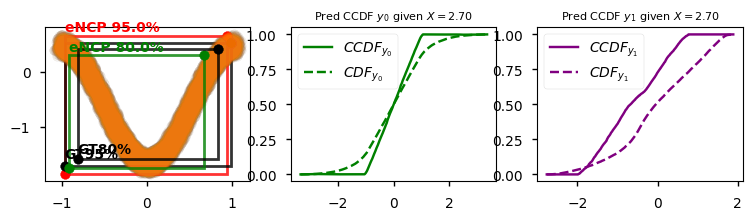

In [ ]:
x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=torch.Tensor([X_cond]).reshape(1, 1))
y = torch.hstack([y_0, y_1])
y_c = (y - y_train_mean) / y_train_std
x_c = (x - x_train_mean) / x_train_std

# Estimate the conditional Cumulative Distribution Function (CCDF)
ccdf = encp_ccdf(x_cond=x_type(x_c))

alphas = [0.05, 0.2]
fig, axs = plt.subplots(1, 3, figsize=(FIG_SIZE[0] * 3, 1 * FIG_SIZE[1]))
for alpha, color in zip(alphas, ["red", "green", "purple"]):
    q_low, q_high = encp_ccdf.conditional_quantiles(x_cond=x_type(x_c), alpha=alpha)
    plot_quantiles(
        y_c, q_low, q_high, label=f"eNCP {(1 - alpha) * 100:.1f}%", alpha=alpha, ax=axs[0], quantile_color=color
    )
    # PLot the marginal CDF of each dimension
axs[1].plot(encp_ccdf.support_obs[:, 0], ccdf[:, 0], label=r"$CCDF_{y_0}$", color="green")
axs[1].plot(
    encp_ccdf.support_obs[:, 0], encp_ccdf.marginal_CDF[:, 0], label=r"$CDF_{y_0}$", color="green", linestyle="--"
)
axs[1].set_title(rf"Pred CCDF $y_0$ given $X={X_cond:.2f}$", fontsize=8)
axs[2].plot(encp_ccdf.support_obs[:, 1], ccdf[:, 1], label=r"$CCDF_{y_1}$", color="purple")
axs[2].plot(
    encp_ccdf.support_obs[:, 1], encp_ccdf.marginal_CDF[:, 1], label=r"$CDF_{y_1}$", color="purple", linestyle="--"
)
axs[2].set_title(rf"Pred CCDF $y_1$ given $X={X_cond:.2f}$", fontsize=8)
axs[1].legend()
axs[2].legend()

fig.savefig(PLOT_PATH / "encp_ccdf_regression.png", dpi=250)

# Comparison: CQR vs NCP vs eNCP
## Qualitative results

To compare all three methods for uncertainty estimation we first visualize the prediction intervals for different conditioning values of $x$.

In the second and third row you will see the predicted Conditional Cumulative Distribution Function (CondCDF) used the `eNCP` an and `NCP` models to estimate the desired quantiles. Both methods learn to approximate the deformation of the marginal CDF given different conditioning values.


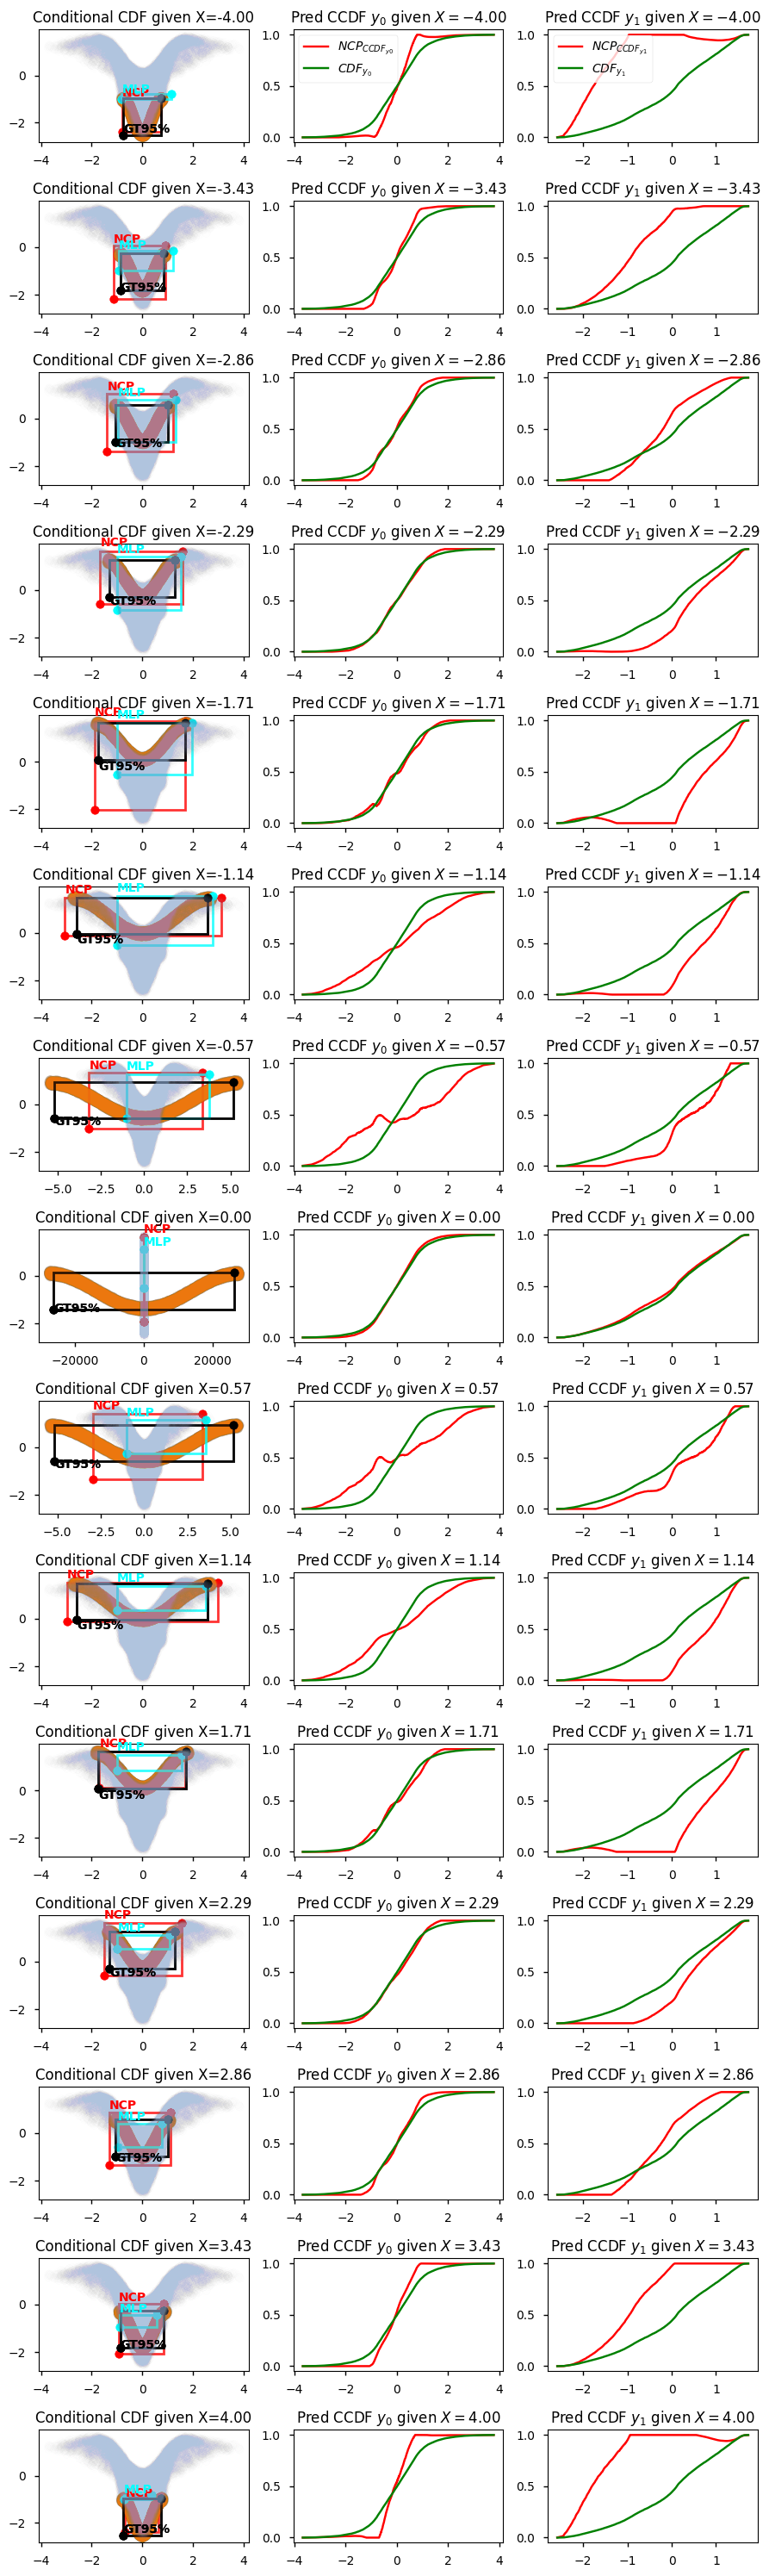

In [11]:
N_COND_POINTS = 15
x_range = torch.linspace(X_MIN, X_MAX, N_COND_POINTS).reshape(-1, 1, 1).to(dtype=torch.float32)

fig, axs = plt.subplots(N_COND_POINTS, 3, figsize=(FIG_SIZE[0] * 3, N_COND_POINTS * FIG_SIZE[1]))
for i, x_cond in enumerate(x_range):
    _, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=torch.Tensor([x_cond]).reshape(1, 1))
    y = torch.hstack([y_0, y_1])
    y_c = (y - y_train_mean) / y_train_std
    x_c = ((x_cond - x_train_mean) / x_train_std).to(DEVICE)

    # NCP quantile predictions.
    q_lo_ncp, q_up_ncp = ncp_ccdf.conditional_quantiles(x_cond=x_c, alpha=ALPHA)
    ccdf = ncp_ccdf(x_cond=x_c)
    # ENCP quantile predictions.
    # q_lo_encp, q_up_encp = encp_ccdf.conditional_quantiles(x_cond=x_type(x_c), alpha=ALPHA)
    # eccdf = encp_ccdf(x_cond=x_type(x_c))
    # MLP quantile predictions.
    q_lo_mlp = torch.squeeze(lower_quantile_estimator(x_c)).detach().cpu().numpy()  # - q_hat
    q_up_mlp = torch.squeeze(upper_quantile_estimator(x_c)).detach().cpu().numpy()  # + q_hat
    # Plot the quantile predictions.
    plot_quantiles(y_c, q_lo_ncp, q_up_ncp, ax=axs[i, 0], label="NCP", alpha=ALPHA, quantile_color="red")
    # plot_quantiles(y_c, q_lo_encp, q_up_encp, ax=axs[i, 0], label="eNCP", alpha=ALPHA, quantile_color="purple")
    plot_quantiles(y_c, q_lo_mlp, q_up_mlp, ax=axs[i, 0], label="MLP", alpha=ALPHA, quantile_color="aqua")
    axs[i, 0].set_title(f"X={x_cond.item():.2f}")
    axs[i, 0].scatter(y_train[:, 0], y_train[:, 1], alpha=0.01, color="lightsteelblue")
    axs[i, 0].set_title(f"Conditional CDF given X={x_cond.item():.2f}")
    axs[i, 1].set_title(rf"Pred CCDF $y_0$ given $X={x_cond.item():.2f}$")
    axs[i, 1].plot(ncp_ccdf.support_obs[:, 0], ccdf[:, 0], label=r"$NCP_{CCDF_{y0}}$", color="red")
    # axs[i, 1].plot(ncp_ccdf.support_obs[:, 0], eccdf[:, 0], label=r"$eNCP_{CCDF_{y0}}$", color="purple")
    axs[i, 1].plot(ncp_ccdf.support_obs[:, 0], ncp_ccdf.marginal_CDF[:, 0], label=r"$CDF_{y_0}$", color="green")
    axs[i, 2].set_title(rf"Pred CCDF $y_1$ given $X={x_cond.item():.2f}$")
    axs[i, 2].plot(ncp_ccdf.support_obs[:, 1], ccdf[:, 1], label=r"$NCP_{CCDF_{y1}}$", color="red")
    # axs[i, 2].plot(ncp_ccdf.support_obs[:, 1], eccdf[:, 1], label=r"$eNCP_{CCDF_{y1}}$", color="purple")
    axs[i, 2].plot(ncp_ccdf.support_obs[:, 1], ncp_ccdf.marginal_CDF[:, 1], label=r"$CDF_{y_1}$", color="green")
    if i == 0:
        axs[i, 1].legend()
        axs[i, 2].legend()
fig.tight_layout()

fig.savefig(PLOT_PATH / "ccdf_regression_comp.png", dpi=300)

# **Quantitative resuts**:
## Coverage and Set Size in Conditional Quantile Regression

### **Setup**
We aim to estimate conditional quantiles of a multivariate random variable $Y \in \mathbb{R}^d$ given another variable $X \in \mathbb{R}^p$. The objective is to construct a prediction set $C(Y \mid X = x)$ that provides reliable uncertainty quantification.

### **Coverage**
Coverage measures the probability that the true value $Y$ lies within the predicted confidence region $C(Y \mid X = x)$ for a given input $X = x$. Formally, it is defined as:

$$
\text{Coverage} = \mathbb{P}(Y \in C(Y \mid X = x) \mid X = x)
$$

For a desired coverage level $1 - \alpha$, we want:

$$
\mathbb{P}(Y \in C(Y \mid X = x) \mid X = x) \approx 1 - \alpha
$$

### **Set Size**
Set Size quantifies the volume or size of the prediction set $C(Y \mid X = x)$, which reflects the model’s uncertainty. For conditional quantile regression, it is calculated as:

$$
\text{Set Size} = \text{Volume}(C(Y \mid X = x)) = \int_{C(Y \mid X = x)} d\mu
$$

where $\mu$ is a suitable measure, typically the Lebesgue measure in $\mathbb{R}^d$.

### **Objective**
The goal is to construct a prediction set $C(Y \mid X = x)$ that maintains the desired coverage level $1 - \alpha$ while minimizing the set size. This trade-off is central to effective uncertainty quantification.


In [ ]:
coverage_ncp, set_size_ncp = test_ncp_uc(model=ncp_ccdf, test_dl=test_dl)
coverage_encp, set_size_encp = test_encp_uc(model=encp_ccdf, test_dl=test_dl)
coverage_mlp, set_size_mlp = test_mlp(
    lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, test_dl=test_dl, q_hat=q_hat
)

# Define the results
results = {
    "Model Type": ["NCP", "ENCP", "CQR"],
    "Coverage": [coverage_ncp.item(), coverage_encp.item(), coverage_mlp.item()],
    "Set Size": [set_size_ncp.item(), set_size_encp.item(), set_size_mlp.item()],
}
# Create a DataFrame
df = pd.DataFrame(results)
df["Coverage"] = df["Coverage"].map("{:.3f}".format)
df["Set Size"] = df["Set Size"].map("{:.3f}".format)
print(df)

# Print latex version of the table:
# Convert the DataFrame to LaTeX format
latex_table = df.to_latex(index=False)  # Set index=False to exclude the index column
# Print the LaTeX table
# print(latex_table)

  Model Type Coverage Set Size
0        NCP    0.971    8.608
1       ENCP    0.933    7.367
2        CQR    0.953   19.741
